# Импорт библиотек

In [1]:
# Загружаем библиотеки
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Подгружаем библиотеки для ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import shap
import pickle

# Для корректного отображения графиков
%matplotlib inline

# Обучение моделей

Результаты StackingRegressor:
- Стэкинг GradientBoostingRegressor и RandomForestRegressor
- R2_score - 0.99 (лучше, чем в ExtraTreesRegressor)
- Наиболее важные признаки, влияющие на плотность: MolLogP, NumHeteroatoms, NumRotatableBonds, MolWt, Temperature. На плотность больше всего влияет тип соединений, а не условия проведения эксперимента и соотношения.

#### Функции для ML

In [26]:
# Выводит график весов, может потребоваться какое то время для выполнения
def feature_importance(model):
    explainer = shap.Explainer(model.predict, X_train, max_evals=1041)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, plot_type='bar')


# Сохраняет веса
def weights_model(name, model):
    if name.endswith('.pkl'):
        with open(name, 'wb') as f:
            pickle.dump(model, f)
    else:
        print('Неправильное название файла')


#### StackingRegressor: GradientBoostingRegressor + RandomForestRegressor

In [38]:
df = pd.read_csv('Final.csv')
df.drop(['Unnamed: 0', ], axis=1, inplace=True)

In [39]:
# Выбираем численные признаки
numeric_columns = df.select_dtypes(include='number').columns.tolist()

In [40]:
# Нормализуем датасет с помощью MinMaxScaller
to_scale_df = df[numeric_columns].copy()
scaled_data = preprocessing.MinMaxScaler().fit_transform(to_scale_df)
scaled_df = pd.DataFrame(scaled_data, columns=to_scale_df.columns)

In [41]:
# разделяем таргет и фичи
X_norm = scaled_df.drop('Density, g/cm^3', axis=1)
y_norm = scaled_df['Density, g/cm^3']

In [42]:
# Разделяем выборки на train и test
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm,
                                                    train_size=0.8,
                                                    random_state=666)

In [43]:
# обучаем GradientBoostingRegressor
model_grboost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.036, subsample=0.6, alpha=0.25)
scores2 = cross_val_score(model_grboost, X_train, y_train, cv=5)
print('Cross validation scores: ', scores2)
print('Mean Score: ', scores2.mean())
model_grboost.fit(X_train, y_train)

Cross validation scores:  [0.99022904 0.97844656 0.9831208  0.96952723 0.98045543]
Mean Score:  0.9803558096830878


GradientBoostingRegressor(alpha=0.25, learning_rate=0.036, n_estimators=1500,
                          subsample=0.6)

In [44]:
# обучаем RandomForestRegressor
model_forest = RandomForestRegressor(n_estimators=150)
model_forest.fit(X_train, y_train)
scores3 = cross_val_score(model_forest, X_train, y_train, cv=5)
print(f'mean score RandomForestRegressor CV: {scores3.mean()}')

mean score RandomForestRegressor CV: 0.9778586163289585


In [45]:
# cтекинг GradientBoostingRegressor и RandomForestRegressor
estims2 = [('gbr', model_grboost), ('forest', model_forest)]
stack = StackingRegressor(estimators=estims2, cv=5)
stack.fit(X_train, y_train)
score_stack = cross_val_score(stack, X_train, y_train, cv=5)
print('Cross validation scores: ', score_stack)
print('Mean Score: ', score_stack.mean())

Cross validation scores:  [0.99277919 0.97812429 0.98608614 0.97425344 0.98160367]
Mean Score:  0.9825693438239439


In [46]:
# Отнормализуем обратно X_test для прогноза
min_val = df['Density, g/cm^3'].min()
max_val = df['Density, g/cm^3'].max()
y_true = y_test * (max_val - min_val) + min_val
y_pred = stack.predict(X_test) * (max_val - min_val) + min_val

In [47]:
# Проверим r2 score для тестовых данных
print("R2-score: %.2f" % r2_score(y_true, y_pred))
# Проверим mse score для тестовых данных
mse = mean_squared_error(y_true, y_pred)
print("MSE: %.4f" % mse)
print('RMSE: %.4f' % np.sqrt(mse) )

R2-score: 0.99
MSE: 0.0002
RMSE: 0.0152


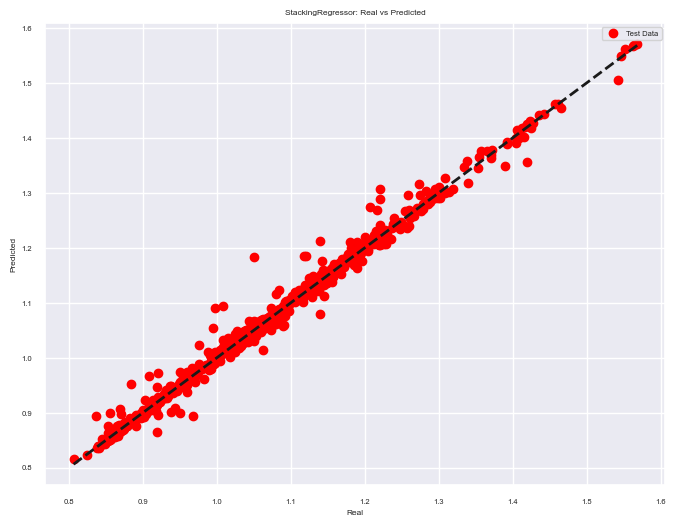

In [48]:
# Построим график сравнения y_test y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='red', label='Test Data')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('StackingRegressor: Real vs Predicted')
plt.legend()
plt.show()

In [49]:
# weights_model('model_stack.pkl', stack)

PermutationExplainer explainer: 759it [26:30,  2.11s/it]                         


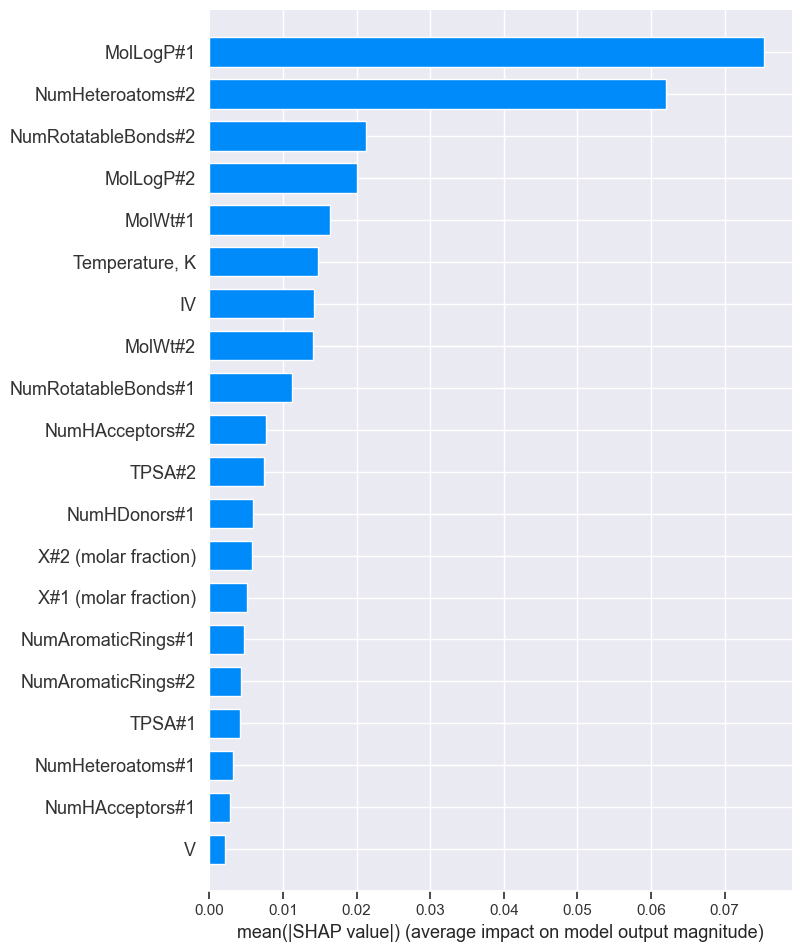

In [50]:
# feature_importance(stack)